In [1]:
import ROOT as r
r.EnableImplicitMT()

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim.lr_scheduler as lr_schedulers
from torch.utils.data import Dataset, DataLoader

import numpy as np
import pandas as pd

from tqdm import tqdm

import matplotlib.pyplot as plt
import mplhep as hep
plt.style.use(hep.style.CMS)

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc

## Dataset

In [2]:
class MyDataset(Dataset):
    def __init__(self, data, transforms={}):
        self.transforms = transforms

        inputs = []
        for var in list(data.keys())[:-3]:
            inputs.append(self.transform(torch.tensor(data[var].to_numpy(), dtype=torch.float), self.transforms.get(var, None)))
        
        self.features = torch.stack(inputs).transpose(0,1)
        self.weights = torch.tensor(data.weight.to_numpy(), dtype=torch.float).unsqueeze(1)
        self.labels = torch.tensor(data.label.to_numpy(), dtype=torch.float).unsqueeze(1)
        self.disco_target = torch.tensor(data.VBSBDTscore.to_numpy(), dtype=torch.float).unsqueeze(1)

        self.weight_norm = torch.ones(self.labels.size())
        self.labels_norm = torch.ones(self.labels.size())

        self.weight_norm[self.labels == 0] = torch.sum(self.labels == 0) / torch.sum(self.weights[self.labels == 0])
        self.weight_norm[self.labels == 1] = torch.sum(self.labels == 1) / torch.sum(self.weights[self.labels == 1])
        self.labels_norm[self.labels == 1] = torch.sum(self.labels == 0) / torch.sum(self.labels == 1)

        
    def __len__(self):
        return len(self.features)

    @staticmethod
    def transform(feature, transf):
        if type(transf) == list:
            transf, params = transf
        if transf == None:
            return feature
        elif transf == "rescale":
            min_value, max_value = params
            return (feature - min_value)/(max_value - min_value)
        elif transf == "log":
            if (feature < 0).any():
                raise ValueError("Log transformation of negative values not supported")
            return torch.log(feature)
        elif transf == "log2":
            return torch.log2(feature)
        elif transf == "log10":
            return torch.log10(feature)
        else:
            raise ValueError(f"transformation '{transf}' not supported")

    def __getitem__(self, idx):
        return self.features[idx], self.labels[idx], self.weights[idx]*self.labels_norm[idx]*self.weight_norm[idx], self.disco_target[idx]
        

# Loss Function

In [3]:
class SingleDisCoLoss(nn.Module):
    def __init__(self, disco_lambda, dCorr_power=1):
        super().__init__()
        self.disco_lambda = disco_lambda
        self.dCorr_power = dCorr_power

    @staticmethod
    def dCorr(var_1, var_2, normed_weight, power):
        xx = var_1.view(-1, 1).repeat(1, len(var_1)).view(len(var_1),len(var_1))
        yy = var_1.repeat(len(var_1),1).view(len(var_1),len(var_1))
        amat = (xx-yy).abs()

        xx = var_2.view(-1, 1).repeat(1, len(var_2)).view(len(var_2),len(var_2))
        yy = var_2.repeat(len(var_2),1).view(len(var_2),len(var_2))
        bmat = (xx-yy).abs()

        amatavg = torch.mean(amat*normed_weight,dim=1)
        Amat=amat-amatavg.repeat(len(var_1),1).view(len(var_1),len(var_1))\
            -amatavg.view(-1, 1).repeat(1, len(var_1)).view(len(var_1),len(var_1))\
            +torch.mean(amatavg*normed_weight)

        bmatavg = torch.mean(bmat*normed_weight,dim=1)
        Bmat=bmat-bmatavg.repeat(len(var_2),1).view(len(var_2),len(var_2))\
            -bmatavg.view(-1, 1).repeat(1, len(var_2)).view(len(var_2),len(var_2))\
            +torch.mean(bmatavg*normed_weight)

        ABavg = torch.mean(Amat*Bmat*normed_weight,dim=1)
        AAavg = torch.mean(Amat*Amat*normed_weight,dim=1)
        BBavg = torch.mean(Bmat*Bmat*normed_weight,dim=1)

        if power == 1:
            dCorr=(torch.mean(ABavg*normed_weight))/torch.sqrt((torch.mean(AAavg*normed_weight)*torch.mean(BBavg*normed_weight)))
        elif power == 2:
            dCorr=(torch.mean(ABavg*normed_weight))**2/(torch.mean(AAavg*normed_weight)*torch.mean(BBavg*normed_weight))
        else:
            dCorr=((torch.mean(ABavg*normed_weight))/torch.sqrt((torch.mean(AAavg*normed_weight)*torch.mean(BBavg*normed_weight))))**power
        return dCorr

    def forward(self, inferences, labels, disco_target, weights):
        BCE = F.binary_cross_entropy(inferences, labels, reduction="mean", weight=weights)
        dCorr = self.dCorr(inferences[labels == 0], disco_target[labels == 0], weights[labels == 0], power=self.dCorr_power)
        return BCE + self.disco_lambda*dCorr, BCE, self.disco_lambda*dCorr


# Model Definition

In [4]:
class NeuralNetwork(nn.Module):
    def __init__(self, input_size, n_hidden_layers, hidden_size):
        super().__init__()

        hidden_layers = []
        for layer_i in range(n_hidden_layers):
            if layer_i == 0:
                hidden_layers.append(nn.Linear(input_size, hidden_size))
                hidden_layers.append(nn.ReLU())
            else:
                hidden_layers.append(nn.Linear(hidden_size, hidden_size))
                hidden_layers.append(nn.ReLU())

        self.layers = nn.Sequential(
            *hidden_layers,
            nn.Linear(hidden_size, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.layers(x)

# Training

In [5]:
def load_data(signal_filename, background_filename):
    def pddf(filename, variables):
        data = r.RDataFrame("Events", filename).Filter("Hbbscore > 0.5").AsNumpy(variables)
        return pd.DataFrame(data)
    
    variables = ["Hbbmass", "HbbPt", "Wjetmass", "WjetPt",  "leptonpt", "Mlbminloose", "MET", "VBSBDTscore", "weight"]

    x_sig = pddf(signal_filename, variables)
    x_bkg = pddf(background_filename, variables)

    x_sig["label"] = 1
    x_bkg["label"] = 0

    df = pd.concat([x_sig, x_bkg], ignore_index=True)
    df = df.sample(frac=1).reset_index(drop=True)

    return df

In [6]:
df = load_data("/ceph/cms/store/user/aaarora/output/sig_MVA.root", "/ceph/cms/store/user/aaarora/output/bkg_MVA.root")
df_train, df_test = train_test_split(df, test_size=0.2, random_state=42)

In [7]:
transform_dict = {
    "Hbbmass" : ["rescale",[50,250]],
    "HbbPt"   : "log",
    "Wjetmass" : ["rescale",[0,200]],
    "WjetPt" : "log",
    "leptonpt" : "log",
    "Mlbminloose" : ["rescale",[0,1000]],
    "MET" : "log"
}

In [8]:
train_data = MyDataset(df_train, transforms=transform_dict)
test_data = MyDataset(df_test, transforms=transform_dict)

In [9]:
n_batches_train, n_batches_test = 20, 10

train_dataloader = DataLoader(train_data, batch_size=len(train_data)//n_batches_train, shuffle=True, drop_last=True, num_workers=4)
test_dataloader = DataLoader(test_data, batch_size=len(test_data)//n_batches_test, shuffle=True, drop_last=True, num_workers=4)

In [10]:
torch.manual_seed(1234)
use_cuda = torch.cuda.is_available()
device = torch.device("cuda:1" if use_cuda else "cpu")

In [11]:
model = NeuralNetwork(7, 3, 64)
model.to(device)

NeuralNetwork(
  (layers): Sequential(
    (0): Linear(in_features=7, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=64, bias=True)
    (5): ReLU()
    (6): Linear(in_features=64, out_features=1, bias=True)
    (7): Sigmoid()
  )
)

In [12]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
scheduler = lr_schedulers.ConstantLR(optimizer, factor=1)
criterion = SingleDisCoLoss(30, 2)

In [13]:
train_loss, test_loss = [], []
for epoch in tqdm(range(1000), desc="Epochs"):
    model.train()
    tr_loss, tr_bce, tr_disco = 0, 0, 0
    te_loss, te_bce, te_disco = 0, 0, 0 
    for batch_i, (features, labels, weights, disco_target) in enumerate(train_dataloader):
        # train
        features, labels, weights, disco_target = features.to(device), labels.to(device), weights.to(device), disco_target.to(device)
        optimizer.zero_grad()
        predictions = model(features)
        if torch.isnan(predictions).any():
            raise ValueError("NaN in predictions")
        loss, bce, disco = criterion(predictions, labels, disco_target, weights)
        tr_loss += loss.item()
        tr_bce += bce.item()
        tr_disco += disco.item()

        loss.backward()
        optimizer.step()

        # test
        if batch_i % 100 == 0:
            model.eval()
            with torch.no_grad():
                for features, labels, weights, disco_target in test_dataloader:
                    features, labels, weights, disco_target = features.to(device), labels.to(device), weights.to(device), disco_target.to(device)
                    predictions = model(features)
                    loss, bce, disco = criterion(predictions, labels, disco_target, weights)
                    te_loss += loss.item()
                    te_bce += bce.item()
                    te_disco += disco.item()
    
    if epoch > 0 and epoch % 250 == 0:
        print(f"Epoch {epoch} - Train Loss: {tr_loss/n_batches_train:.3f} - Test Loss: {te_loss/n_batches_test:.3f}")
        torch.save(model.state_dict(), f"models/model_{epoch}.pt")

    train_loss.append([tr_loss/n_batches_train, tr_bce/n_batches_train, tr_disco/n_batches_train])
    test_loss.append([te_loss/n_batches_test, te_bce/n_batches_test, te_disco/n_batches_test])

    scheduler.step()

Epochs:  25%|██▌       | 251/1000 [11:15<30:52,  2.47s/it]

Epoch 250 - Train Loss: 0.359 - Test Loss: 0.355


Epochs:  50%|█████     | 501/1000 [20:22<17:06,  2.06s/it]

Epoch 500 - Train Loss: 0.349 - Test Loss: 0.346


Epochs:  57%|█████▋    | 566/1000 [22:44<17:26,  2.41s/it]


KeyboardInterrupt: 

## Save Model for Inferences

In [14]:
device = torch.device("cpu")

In [15]:
model.to(device)
sm = torch.jit.script(model)
sm.save("model.pt")

# Validation

In [16]:
train_loss = np.array(train_loss)
test_loss = np.array(test_loss)

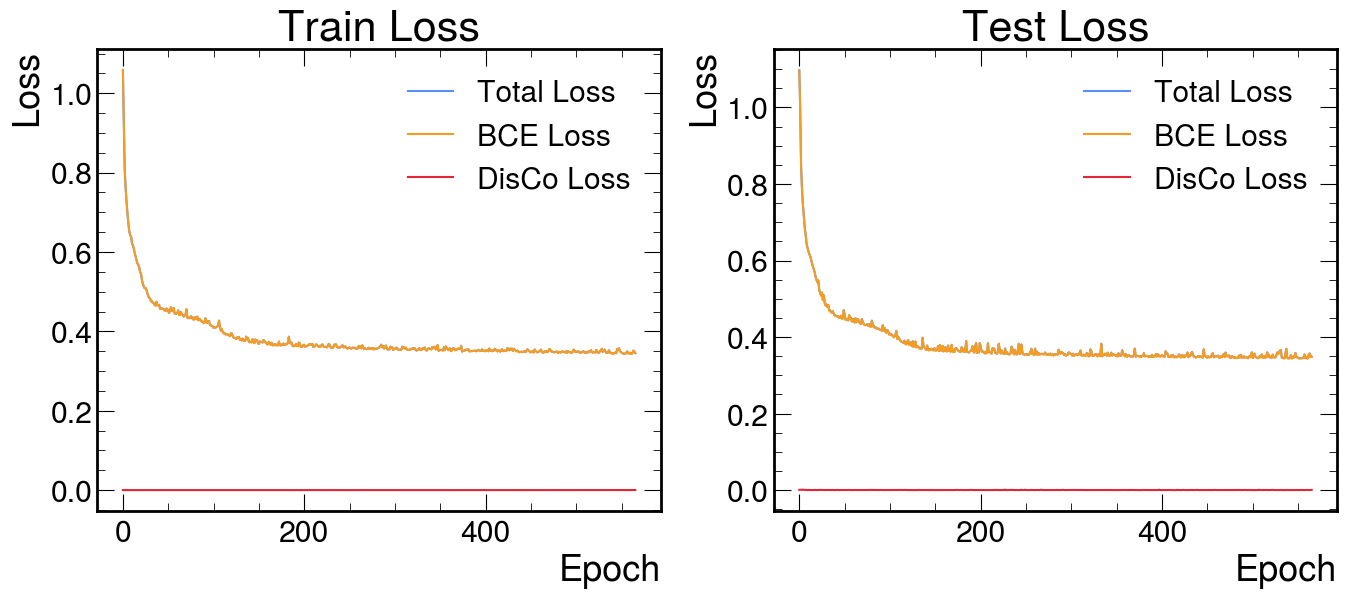

In [17]:
fig, ax = plt.subplots(1, 2, figsize=(16, 6))

ax[0].plot(train_loss[:,0], label="Total Loss")
ax[0].plot(train_loss[:,1], label="BCE Loss")
ax[0].plot(train_loss[:,2], label="DisCo Loss")

ax[1].plot(test_loss[:,0], label="Total Loss")
ax[1].plot(test_loss[:,1], label="BCE Loss")
ax[1].plot(test_loss[:,2], label="DisCo Loss")

ax[0].set_xlabel("Epoch")
ax[0].set_ylabel("Loss")

ax[1].set_xlabel("Epoch")
ax[1].set_ylabel("Loss")

ax[0].set_title("Train Loss")
ax[1].set_title("Test Loss")

ax[0].legend()
ax[1].legend()

In [18]:
prediction_test = model(test_data.features.to(device))
y_pred_test = prediction_test.squeeze(-1).detach().cpu().numpy()

fpr_test, tpr_test, _= roc_curve(test_data.labels, y_pred_test)
roc_auc_test = auc(fpr_test, tpr_test)

prediction_train = model(train_data.features.to(device))
y_pred_train = prediction_train.squeeze(-1).detach().cpu().numpy()

fpr_train, tpr_train, _= roc_curve(train_data.labels, y_pred_train)
roc_auc_train = auc(fpr_train, tpr_train)

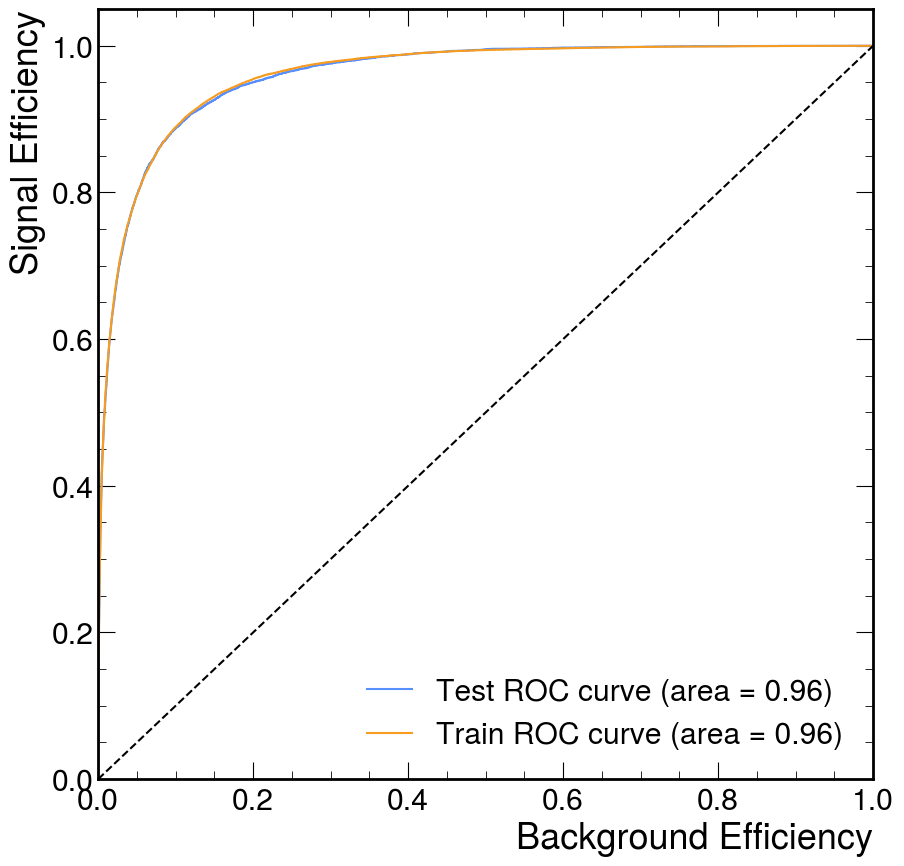

In [19]:
fig, ax = plt.subplots()

ax.plot(fpr_test, tpr_test, label='Test ROC curve (area = %0.2f)' % roc_auc_test)
ax.plot(fpr_train, tpr_train, label='Train ROC curve (area = %0.2f)' % roc_auc_train)

ax.plot([0, 1], [0, 1], 'k--')
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.05])
ax.set_xlabel('Background Efficiency')
ax.set_ylabel('Signal Efficiency')
ax.legend()